# Imports and setup

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoDiagonalNormal

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline, DirichletSpline, TruncatedNormal1DSplineMixture
from stream_membership.plot import plot_data_projections

import astropy.table as at
import astropy.units as u

import pickle
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [3]:
import importlib
import sys
sys.path.append('../../')
sys.path.append('/Users/Tavangar/Work/CATS_workshop/cats/')

import scripts.initialize_stream as init_stream
from scripts.run_full_gd1_model import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

In [4]:
data = at.Table.read("/Users/Tavangar/Work/CATS_Workshop/cats/data/joined-GD-1.fits")

pawprint,iso_obj,iso_mask,hb_mask,pmsel,pm_mask = run_CATS(data, stream_name='GD-1', phi1_lim=[-100,20])

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track
-40.18182129005669
Fitting for peak pm location
Pre-fitting mean PM values: -13.031, -3.108
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [np.float64(-13.271475187973863), np.float64(-3.1697646472516334), np.float64(0.5058218775428639), np.float64(0.3829921285438014)] 

Producing the polygon and mask


In [5]:
run_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask)]
run_data = {k: jnp.array(run_data_[k], dtype="f8") for k in run_data_.colnames}

bkg_data_ = iso_obj.cat[pm_mask & (iso_mask | hb_mask) & ~iso_obj.on_skymask]
bkg_data = {k: jnp.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}


stream_data_ = iso_obj.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & iso_obj.on_skymask]
stream_data = {k: jnp.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

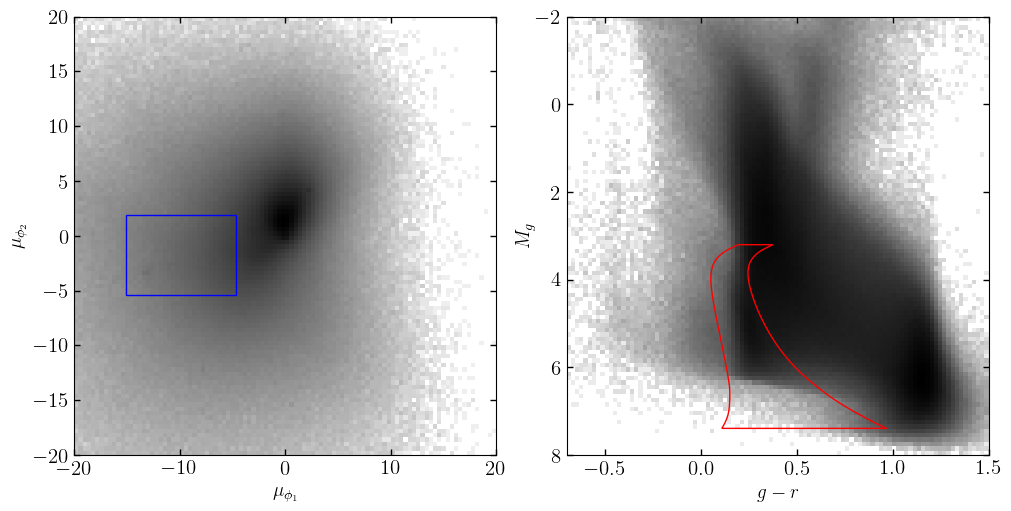

In [6]:
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, edgecolor="red", facecolor="none")

pm_poly = iso_obj.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, edgecolor="blue", facecolor="none")

distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(iso_obj.cat["phi1"]) - iso_obj.dist_mod

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
ax1.hist2d(iso_obj.cat['pm1'], iso_obj.cat['pm2'], cmap='gray_r', bins=100, range=[[-20,20],[-20,20]], 
           norm=mpl.colors.LogNorm(), rasterized=True)
ax1.add_patch(pm_patch)
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

ax2.hist2d(iso_obj.cat['g0'] - iso_obj.cat['r0'], iso_obj.cat['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
           bins=100, range=[[-0.7,1.5],[-2,8]], norm=mpl.colors.LogNorm(), rasterized=True, cmap='gray_r')
ax2.add_patch(cmd_patch)
ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(8, -2)

ax1.set_xlabel(r'$\mu_{\phi_1}$', fontsize=14)
ax1.set_ylabel(r'$\mu_{\phi_2}$', fontsize=14)

ax2.set_xlabel(r'$g-r$', fontsize=14)
ax2.set_ylabel(r'$M_g$', fontsize=14, labelpad=0.1)
# plt.savefig('../../paper_figures/gd1_cuts.pdf')
plt.show()

In [7]:
coord_bounds, plot_grids = init_stream.get_bounds_and_grids(run_data, pawprint)
    
phi1_lim = coord_bounds['phi1']
phi2_lim = coord_bounds['phi2']
pm1_lim  = coord_bounds['pm1']
pm2_lim  = coord_bounds['pm2']

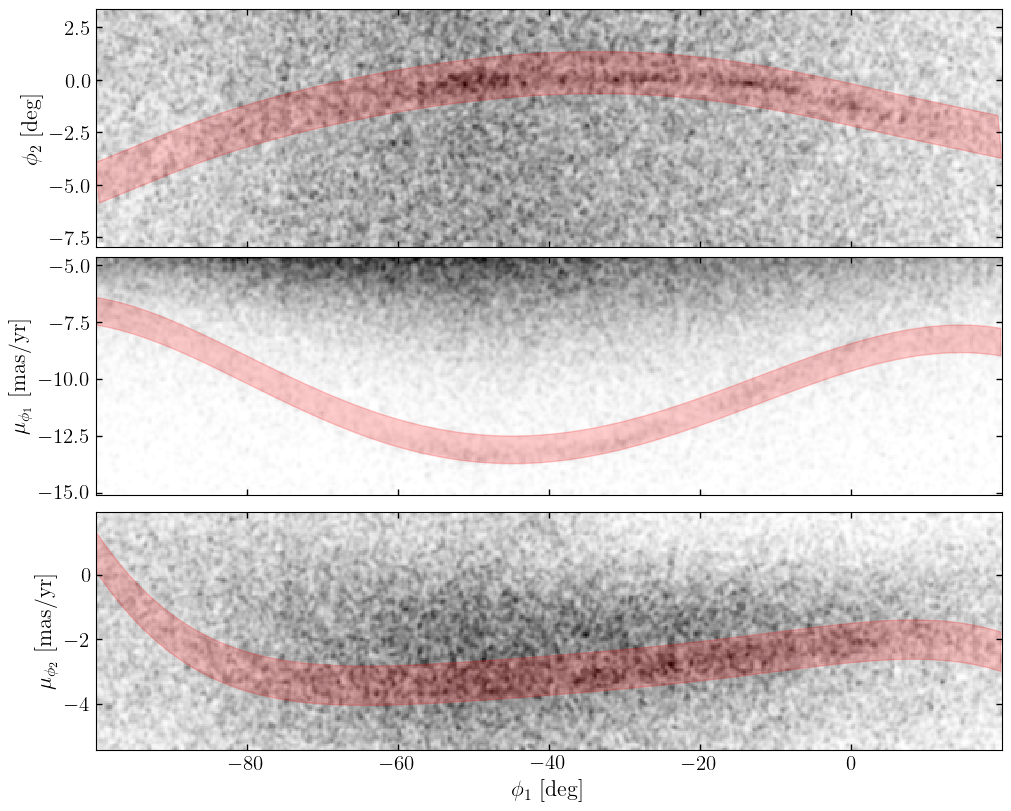

In [8]:
patch_sky = mpl.patches.Polygon(
            iso_obj.pawprint.skyprint["stream"].vertices[::50],
            facecolor="r",
            edgecolor="r",
            linewidth=1,
            alpha=0.2
        )

spline_phi2, spline_pm1, spline_pm2, _ = pmsel.from_galstreams()

fig, axes, _ = plot_data_projections(data=run_data, grids=plot_grids,
                      smooth=1, pcolormesh_kwargs={'rasterized':True, 'cmap':'gray_r'});
axes[0].add_patch(patch_sky)
phi1_array = jnp.arange(-100, 20, 0.2)
axes[1].fill_between(phi1_array, spline_pm1(phi1_array)+jnp.exp(-0.5), spline_pm1(phi1_array)-jnp.exp(-0.5), 
                     color='r', alpha=0.2)
axes[2].fill_between(phi1_array, spline_pm2(phi1_array)+jnp.exp(-0.5), spline_pm2(phi1_array)-jnp.exp(-0.5), 
                     color='r', alpha=0.2)
# axes[1].add_patch(patch_pm1)
# axes[2].add_patch(patch_pm2)
# plt.savefig('../paper_figures/gd1_data.pdf')
plt.show()

# Background

In [9]:
importlib.reload(init_stream)

<module 'initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/scripts/initialize_stream.py'>

In [13]:
bkg_knot_spacings=[40,40,40]
n_pm_mixture=2

bkg_model = init_stream.make_bkg_model_component(knot_spacings=bkg_knot_spacings, n_pm_mixture=n_pm_mixture, 
                                                 coord_bounds=coord_bounds, data=bkg_data)

In [14]:
n_phi1_knots = bkg_model.coord_parameters['phi1']['locs'].shape[-1]
n_pm1_knots = bkg_model.coord_parameters['pm1']['knots'].shape[-1]
n_pm2_knots = bkg_model.coord_parameters['pm2']['knots'].shape[-1]

bkg_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(n_phi1_knots) / n_phi1_knots,
        "scales": 0.5*bkg_knot_spacings[0]
    },
    "phi2": {},
    "pm1": {
        "mixing_distribution": jnp.ones(n_pm_mixture) / n_pm_mixture,
        "loc_vals": jnp.full((n_pm_mixture, n_pm1_knots), 0),
        "scale_vals": jnp.full((n_pm_mixture, n_pm1_knots), 5.0),
    },
    "pm2": {
        "mixing_distribution": jnp.ones(n_pm_mixture) / n_pm_mixture,
        "loc_vals": jnp.full((n_pm_mixture, n_pm2_knots), -3.0),
        "scale_vals": jnp.full((n_pm_mixture, n_pm2_knots), 3.0),
    }
}

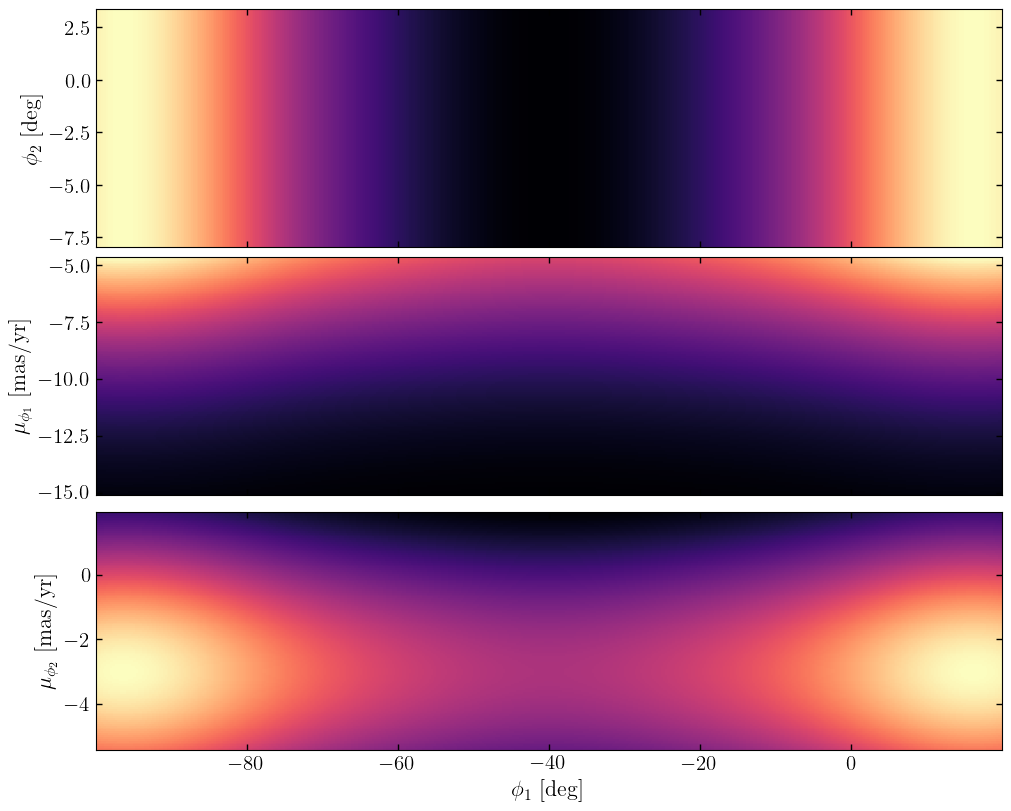

In [15]:
_ = bkg_model.plot_model_projections(pars=bkg_init_params, grids=plot_grids, pcolormesh_kwargs=dict(rasterized=True))

In [47]:
optimizer = numpyro.optim.Adam(1e-2)
guide_bkg = AutoNormal(
    bkg_model, init_loc_fn=numpyro.infer.init_to_value(values=bkg_init_params)
)
MAP_svi_bkg = SVI(bkg_model, guide_bkg, optimizer, Trace_ELBO())

In [49]:
rng_keys = jax.random.split(jax.random.PRNGKey(42), num=3)
with numpyro.validation_enabled(), jax.debug_nans():
    init_state = MAP_svi_bkg.init(rng_keys[0], init_params=bkg_init_params, data=bkg_data)
    MAP_svi_results_bkg = MAP_svi_bkg.run(
    rng_key=rng_keys[1], num_steps=5_000, init_state=init_state, data=bkg_data,
    )

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 3878/5000 [07:32<02:10,  8.57it/s, init loss: 867257.4226, avg. loss [3501-3750]: 622677.8884]


KeyboardInterrupt: 

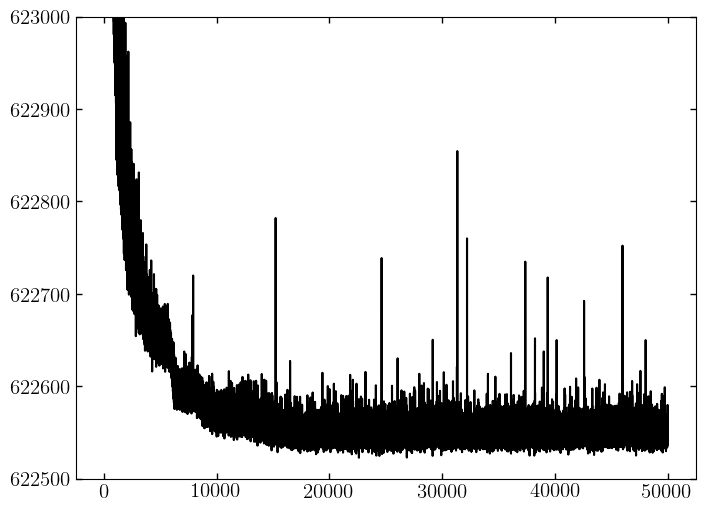

In [16]:
plt.plot(MAP_svi_results_bkg.losses)
# plt.yscale("symlog")
plt.ylim(6.225e5, 6.23e5)

pred_dist_bkg = Predictive(guide_bkg, params=MAP_svi_results_bkg.params, num_samples=1)
MAP_p_bkg_ = pred_dist_bkg(jax.random.PRNGKey(42), data=bkg_data)
MAP_p_bkg = {k: jnp.median(v, axis=0) for k, v in MAP_p_bkg_.items()}
MAP_p_bkg_expanded = bkg_model.expand_numpyro_params(MAP_p_bkg)

Note: We need to keep the number of samples created as 1 because when taking the median, I might get values of the mixing probabilities that do not sum to 1, making them unable 
to be used as initial parameters for the component mixture models. One alternative would be to take the median of one of the mixing probabilities and to fix the other one such that they sum to 1.
Or not!

Can I get the mixing distributions to be splines as well??? Do I need to, given how good the background looks already?

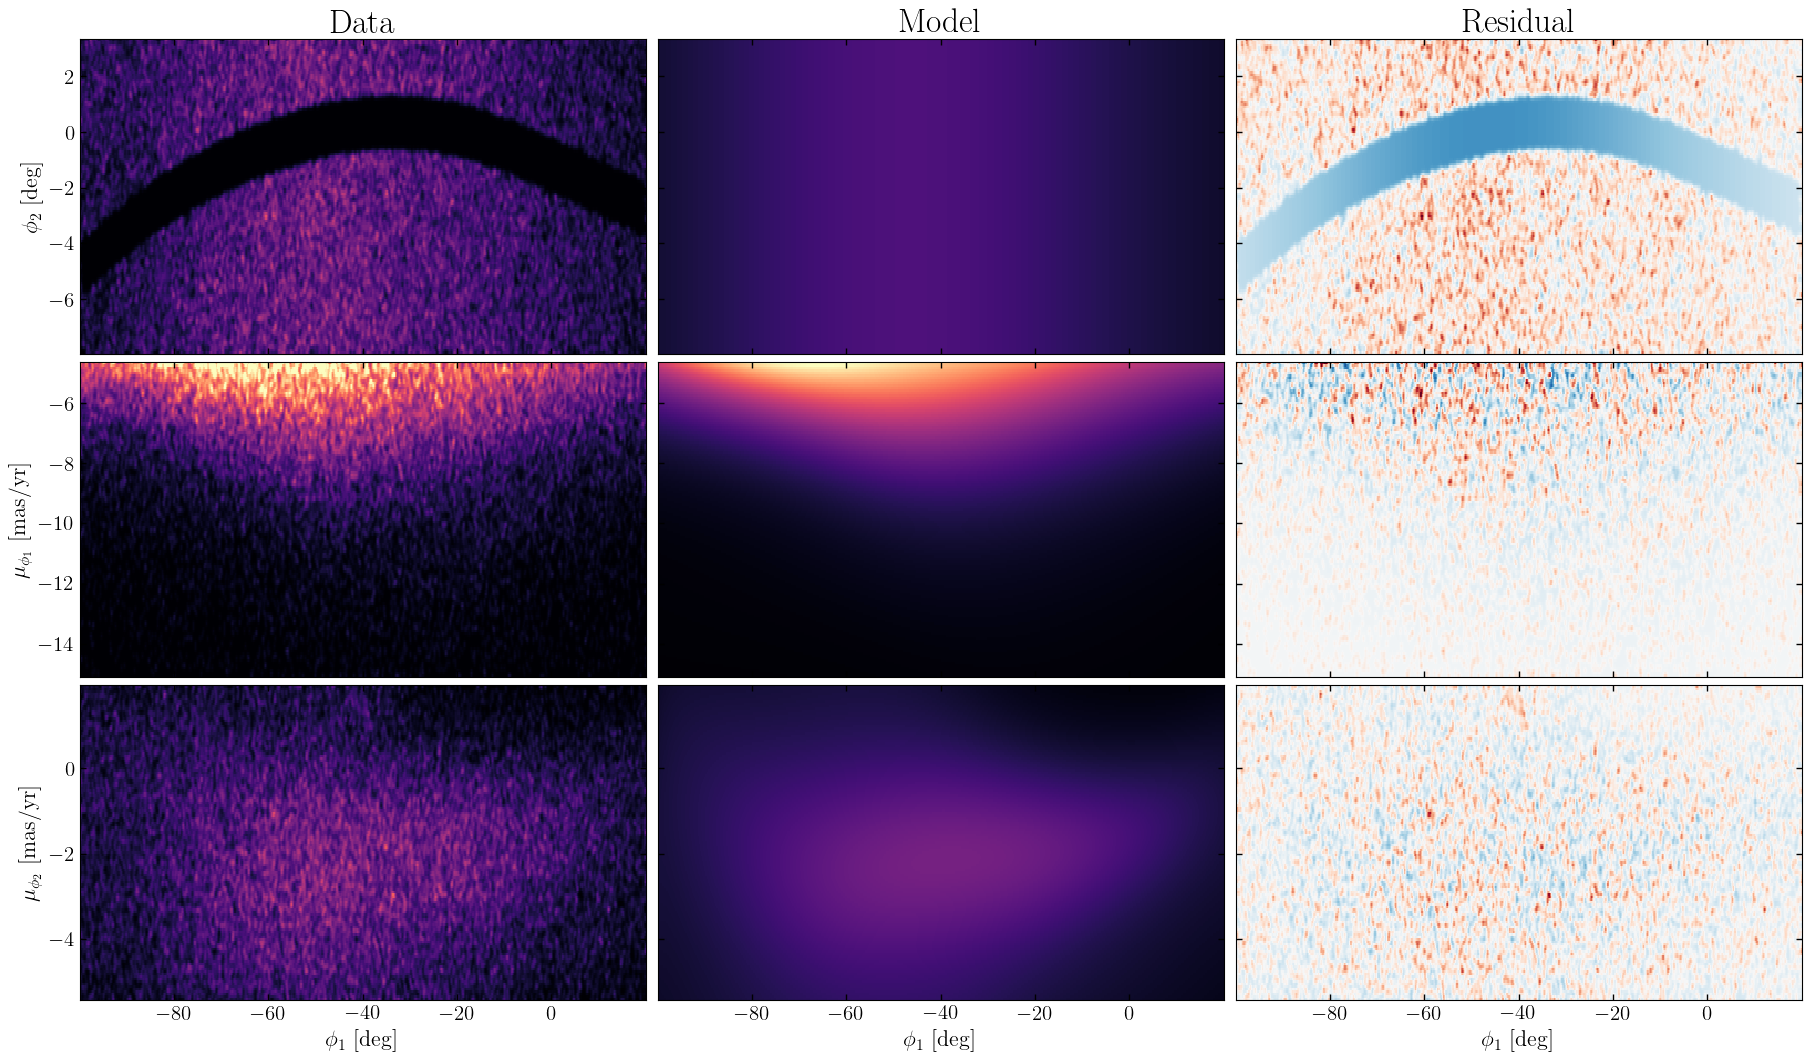

In [18]:
fig, axes = plt.subplots(
    len(bkg_model.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(bkg_model.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0)
    # coord_names=GD1BackgroundModel.coord_names,
)
bkg_model.plot_model_projections(data=bkg_data, grids=plot_grids, pars=MAP_p_bkg_expanded, axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0))

bkg_model.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_bkg_expanded,
    data=bkg_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-2, vmax=2, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

# Stream

In [78]:
importlib.reload(init_stream)

<module 'scripts.initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/notebooks/Pipeline-GD-1/../../scripts/initialize_stream.py'>

Can I / should I be a bit more rigid with the priors on the edges of GD-1? Notice that without that, the left edge of the stream deviates significantly away from what other studeis have shown in the full model a bit below (this is not a problem with the stream model by itself since it is trained on only the data around the galstreams track). It is probably worth it to run once where the phi2_mean is limited to a certain range above/below the galstreams track to see if we pick up more stars that way.

In [16]:
stream_knot_spacings=[5,20,20,20]

stream_model = init_stream.make_stream_model_component(knot_spacings=stream_knot_spacings, coord_bounds=coord_bounds, data=stream_data)

In [17]:
stream_phi1_knots = stream_model.coord_parameters['phi1']['locs'][0]
stream_phi2_knots = stream_model.coord_parameters['phi2']['knots']
stream_pm1_knots = stream_model.coord_parameters['pm1']['knots']
stream_pm2_knots = stream_model.coord_parameters['pm2']['knots']

_interp_dict = init_stream.interpolate_stream_tracks(stream_data, phi1_lim)
eval_interp_phi2 = jnp.array(_interp_dict['phi2'](stream_phi2_knots))
eval_interp_pm1 = jnp.array(_interp_dict['pm1'](stream_pm1_knots))
eval_interp_pm2 = jnp.array(_interp_dict['pm2'](stream_pm2_knots))

stream_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(len(stream_phi1_knots))
        / len(stream_phi1_knots),
        "scales": 10.0,
    },
    "phi2": {
        "loc_vals": eval_interp_phi2,
        "scale_vals": jnp.full(stream_phi2_knots.shape[0], 0.5),
    },
    "pm1": {
        "loc_vals": eval_interp_pm1,
        "scale_vals": jnp.full(stream_pm1_knots.shape[0], 0.35),
    },
    "pm2": {
        "loc_vals": eval_interp_pm2,
        "scale_vals": jnp.full(stream_pm2_knots.shape[0], 0.35),
    },
}

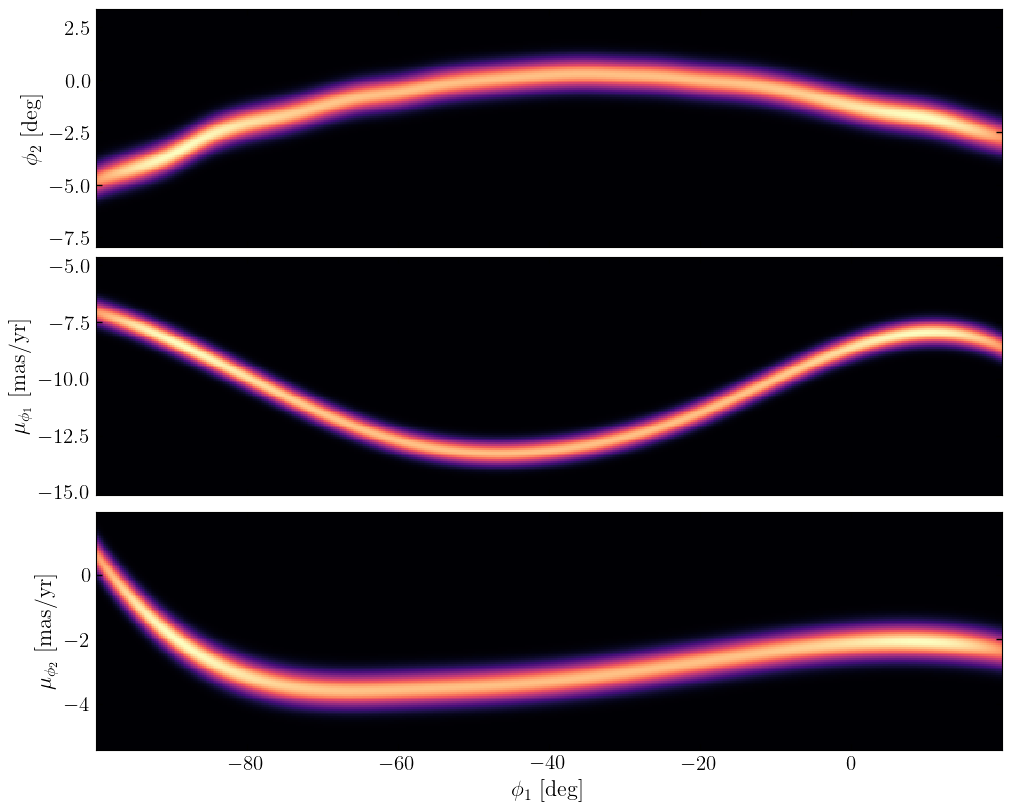

In [197]:
_ = stream_model.plot_model_projections(data=stream_data, pars=stream_init_params, grids=plot_grids)

In [20]:
optimizer = numpyro.optim.Adam(1e-2)
guide_stream = AutoNormal(
    stream_model, init_loc_fn=numpyro.infer.init_to_value(values=stream_init_params)
)
MAP_svi_stream = SVI(stream_model, guide_stream, optimizer, Trace_ELBO())

In [21]:
rng_key = jax.random.PRNGKey(12345)
with numpyro.validation_enabled(), jax.debug_nans():
    init_state = MAP_svi_stream.init(rng_key, init_params=stream_init_params, data=stream_data)
    MAP_svi_results_stream = MAP_svi_stream.run(
    rng_key=jax.random.PRNGKey(54321), num_steps=20_000, init_state=init_state, data=stream_data,
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 245.79it/s, init loss: 155137.6562, avg. loss [19001-20000]: 8198.1378]


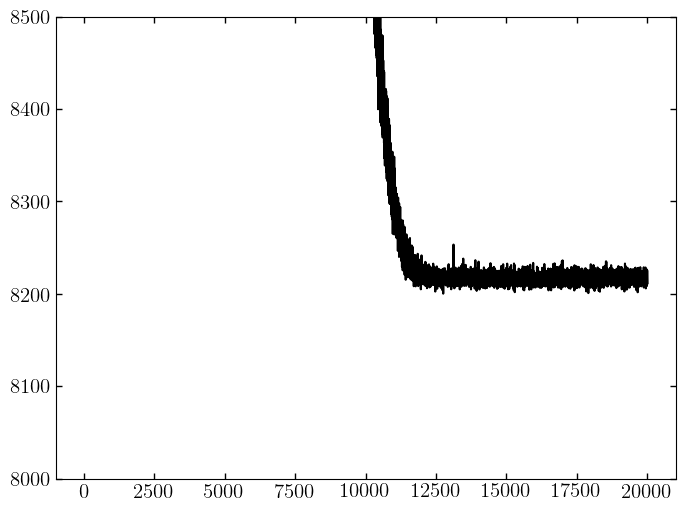

In [17]:
plt.plot(MAP_svi_results_stream.losses)
# plt.yscale("symlog")
plt.ylim(8e3,8.5e3)

pred_dist_stream = Predictive(guide_stream, params=MAP_svi_results_stream.params, num_samples=1)
MAP_p_stream = pred_dist_stream(jax.random.PRNGKey(42), data=stream_data)
MAP_p_stream = {k: jnp.median(v, axis=0) for k, v in MAP_p_stream.items()}
MAP_p_stream_expanded = stream_model.expand_numpyro_params(MAP_p_stream)

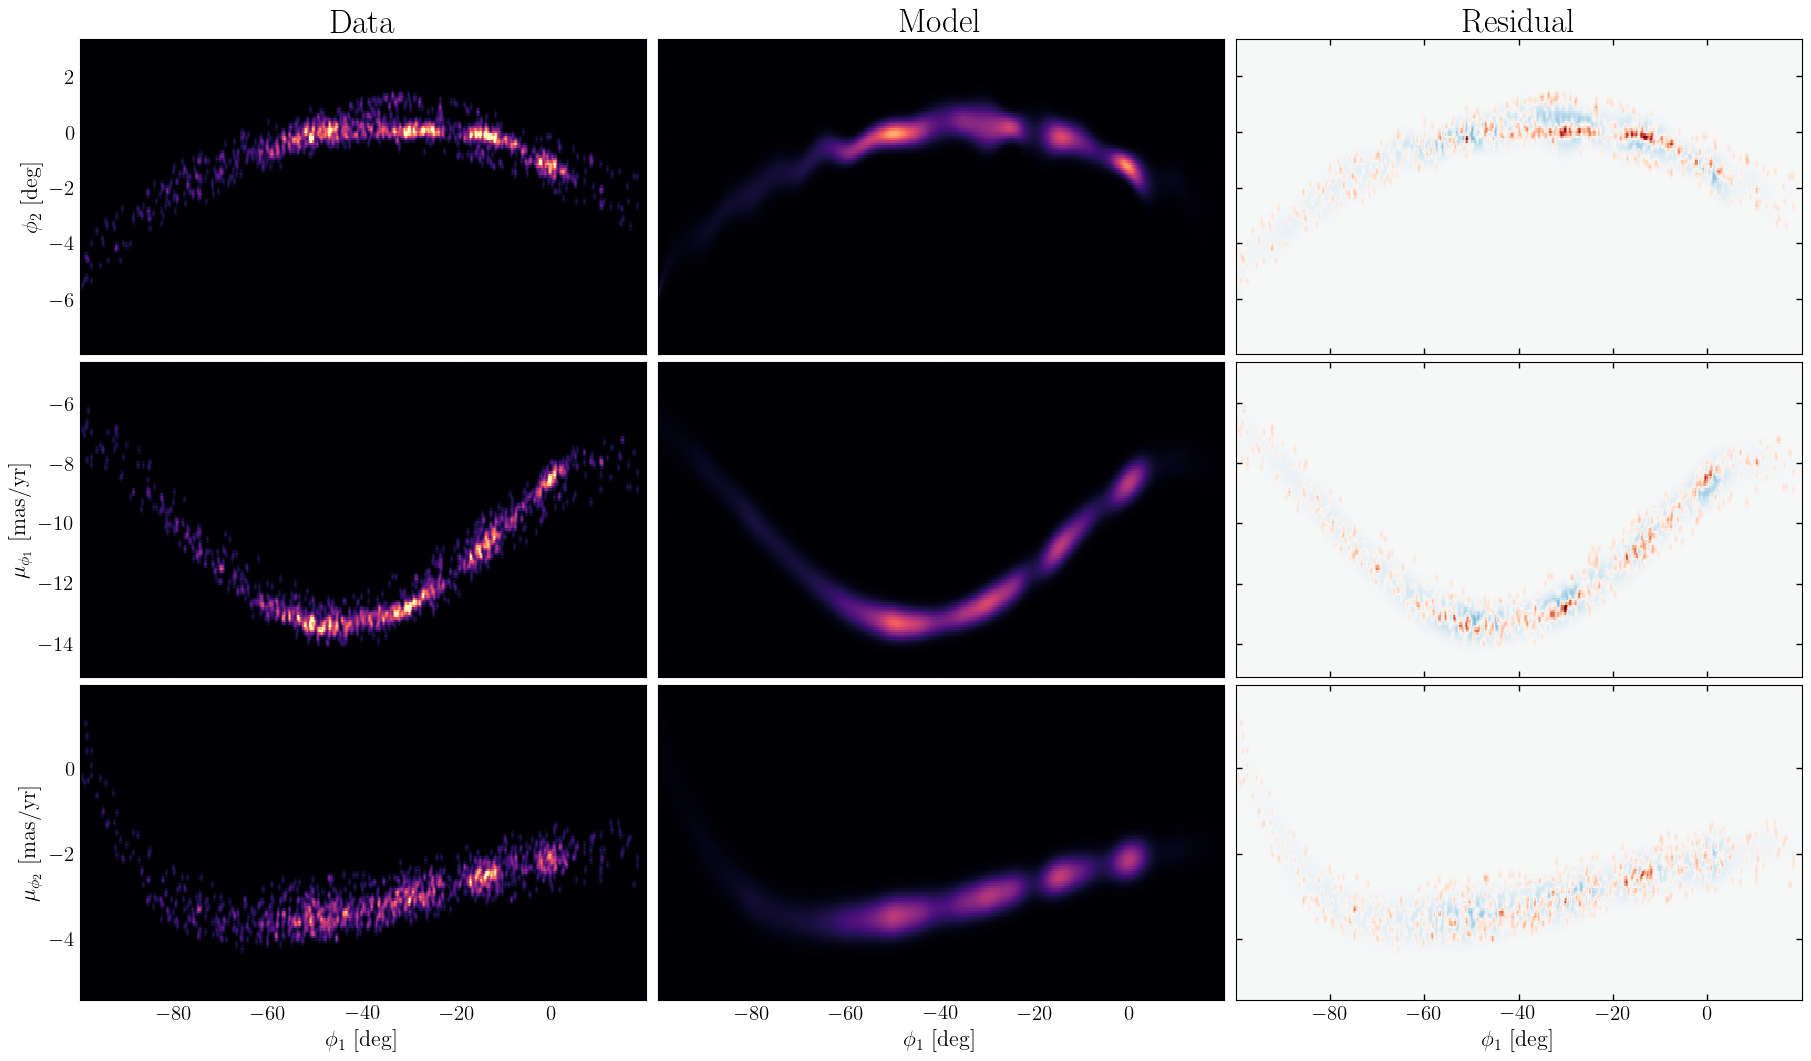

In [201]:
fig, axes = plt.subplots(
    len(stream_model.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_model.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0)
    # coord_names=GD1BackgroundModel.coord_names,
)
stream_model.plot_model_projections(data=stream_data, grids=plot_grids, pars=MAP_p_stream_expanded, axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=1, vmin=0))

stream_model.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_stream_expanded,
    data=stream_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

# Mixture of Stream + Background (no off-track)

In [202]:
importlib.reload(init_stream)

<module 'scripts.initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/notebooks/Pipeline-GD-1/../../scripts/initialize_stream.py'>

In [18]:
bkg_model = init_stream.make_bkg_model_component(knot_spacings=bkg_knot_spacings, n_pm_mixture=n_pm_mixture, 
                                                 coord_bounds=coord_bounds, data=run_data)

stream_model = init_stream.make_stream_model_component(knot_spacings=stream_knot_spacings, 
                                                       coord_bounds=coord_bounds, data=run_data)

In [19]:
stream_bkg_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])), components=[bkg_model, stream_model]
)

In [20]:
f_stream = jnp.around(len(stream_data_)/len(run_data_), 3)
print(f_stream)

0.02


In [21]:
init_params = {"background": MAP_p_bkg_expanded, "stream": MAP_p_stream_expanded}
packed_params = stream_bkg_mm.pack_params(init_params)
packed_params["mixture-probs"] = jnp.array([1-f_stream, f_stream])
packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

_ = stream_bkg_mm.plot_model_projections(data=run_data, pars=packed_params, grids=plot_grids)

NameError: name 'MAP_p_bkg_expanded' is not defined

In [209]:
optimizer = numpyro.optim.Adam(1e-2)
guide_no_off = AutoNormal(
    stream_bkg_mm, init_loc_fn=numpyro.infer.init_to_value(values=packed_params)
)
MAP_svi_no_off = SVI(stream_bkg_mm, guide_no_off, optimizer, Trace_ELBO())

In [210]:
rng_key = jax.random.PRNGKey(12345)
with numpyro.validation_enabled(), jax.debug_nans():
    init_state = MAP_svi_no_off.init(rng_key, init_params=packed_params, data=run_data)
    MAP_svi_results_no_off = MAP_svi_no_off.run(
    rng_key=jax.random.PRNGKey(54321), num_steps=10_000, init_state=init_state, data=run_data
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [41:05<00:00,  4.06it/s, init loss: 769958.2590, avg. loss [9501-10000]: 768165.2427]


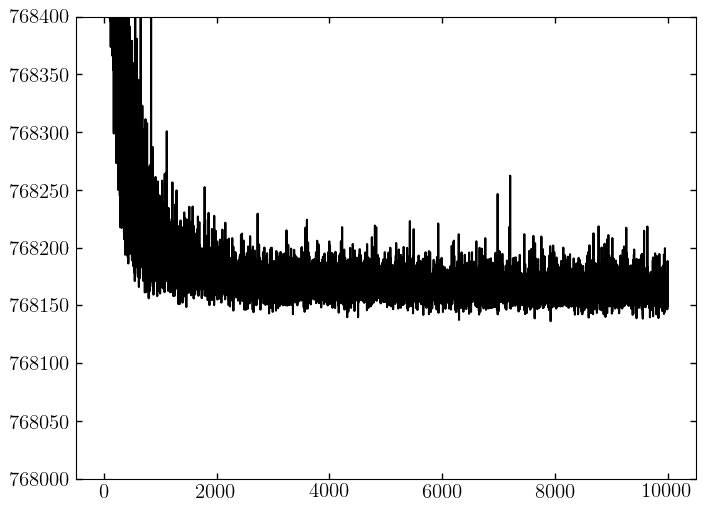

In [211]:
plt.plot(MAP_svi_results_no_off.losses)
# plt.yscale("symlog")
plt.ylim(7.68e5,7.684e5)

pred_dist = Predictive(guide_no_off, params=MAP_svi_results_no_off.params, num_samples=1)
MAP_p_no_off_ = pred_dist(jax.random.PRNGKey(42), data=run_data)
MAP_p_no_off = {k: jnp.median(v, axis=0) for k, v in MAP_p_no_off_.items()}
MAP_p_no_off_expanded = stream_bkg_mm.expand_numpyro_params(MAP_p_no_off)

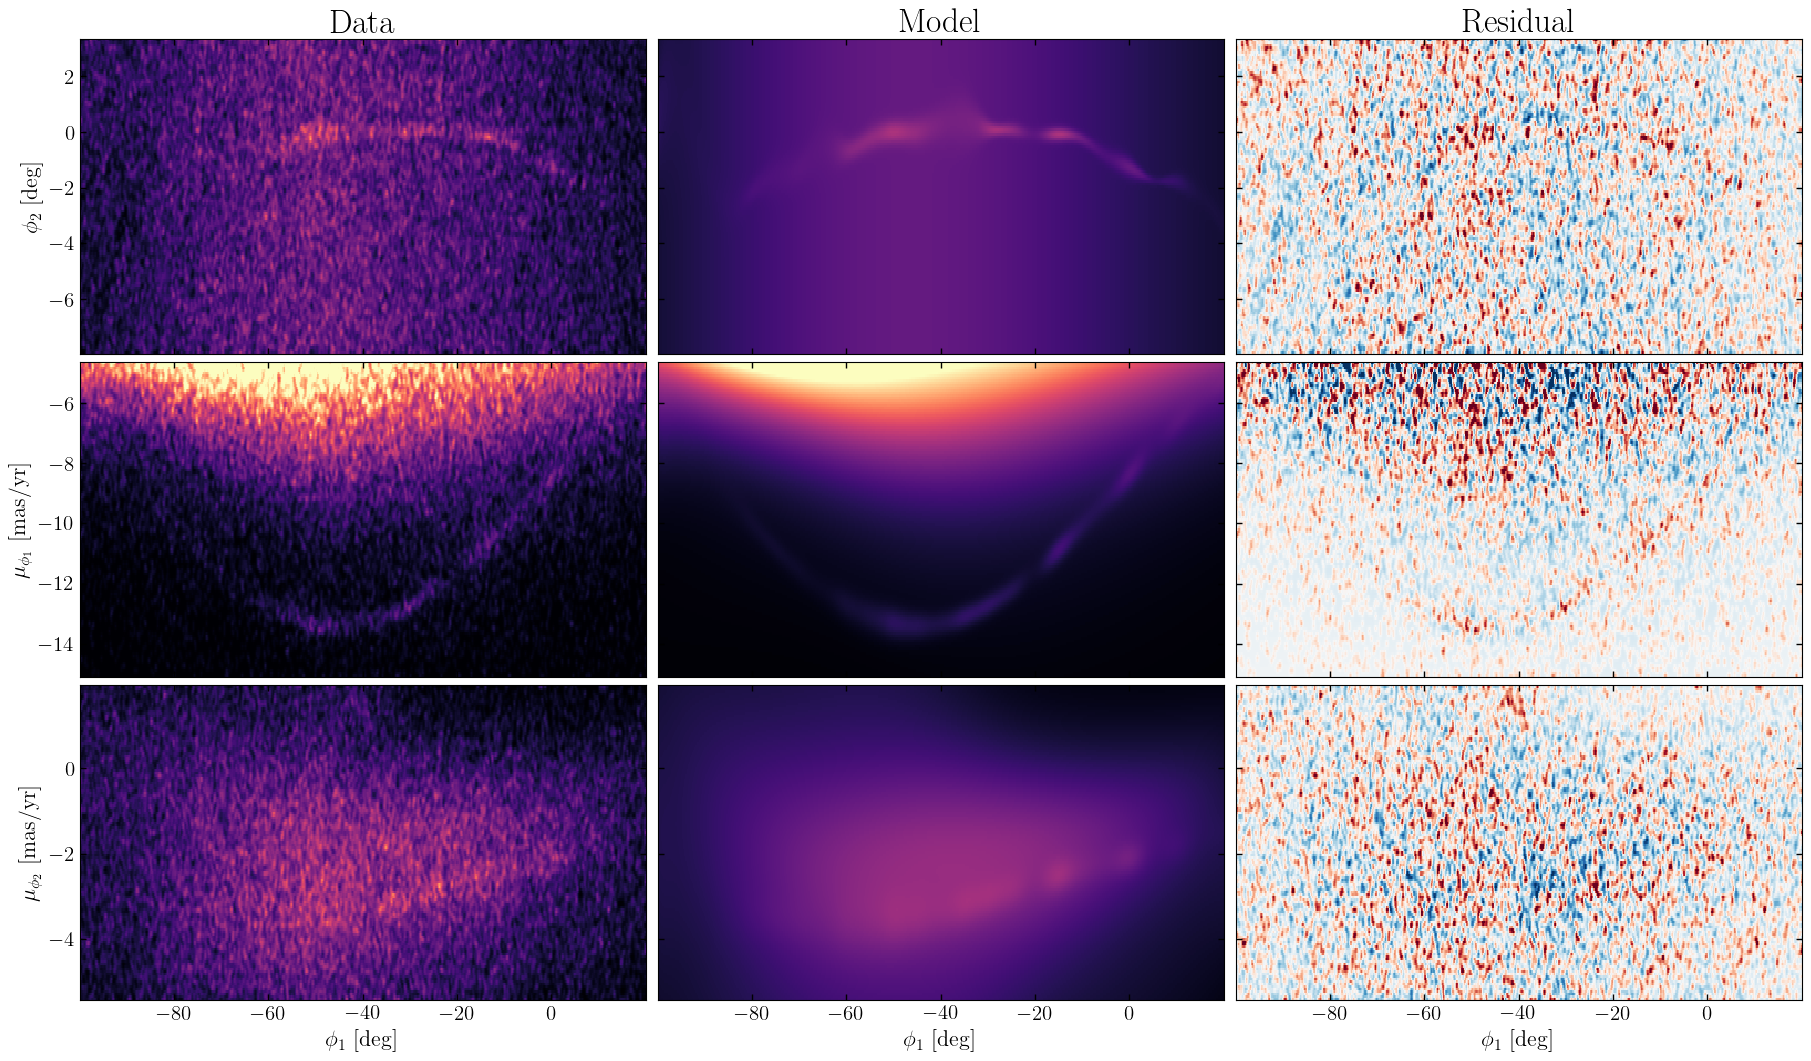

In [212]:
fig, axes = plt.subplots(
    len(stream_bkg_mm.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(stream_bkg_mm.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0)
    # coord_names=GD1BackgroundModel.coord_names,
)
stream_bkg_mm.plot_model_projections(data=run_data, grids=plot_grids, pars=MAP_p_no_off_expanded, axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0))
stream_bkg_mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_no_off_expanded,
    data=run_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

In [95]:
# with open('../data/mix_opt_params.pkl', 'wb') as output:
#     pickle.dump(mix_opt_pars, output)

# Off-track

We also include an "off-track" model that uses the 2D grid of Normals for the sky distribution but uses the same $\mu_{\phi_i}$ tracks as the stream model.

In [22]:
importlib.reload(init_stream)

<module 'initialize_stream' from '/Users/Tavangar/Work/gd1-dr3/scripts/initialize_stream.py'>

In [23]:
offtrack_dx=[3,1]

offtrack_model, offtrack_phi12_locs = init_stream.make_offtrack_model_component(offtrack_dx, stream_model, coord_bounds)

In [75]:
# _init_prob = (
#     jnp.exp(-0.5 * (offtrack_phi12_locs[:, 0] - -35) ** 2 / 4**2)
#     * jnp.exp(-0.5 * (offtrack_phi12_locs[:, 1] - 1.5) ** 2 / 0.5**2)
#     + 1e-5
# )
_init_prob = jnp.ones(len(offtrack_phi12_locs))
_init_prob /= _init_prob.sum()

offtrack_init_params = {
    ("phi1", "phi2"): {
        "mixing_distribution": _init_prob,
        "scales": jnp.array([offtrack_dx] * len(offtrack_phi12_locs)).T,
    },
    "pm1": MAP_p_no_off_expanded['stream']['pm1'],
    "pm2": MAP_p_no_off_expanded['stream']['pm2'],
}

NameError: name 'MAP_p_no_off_expanded' is not defined

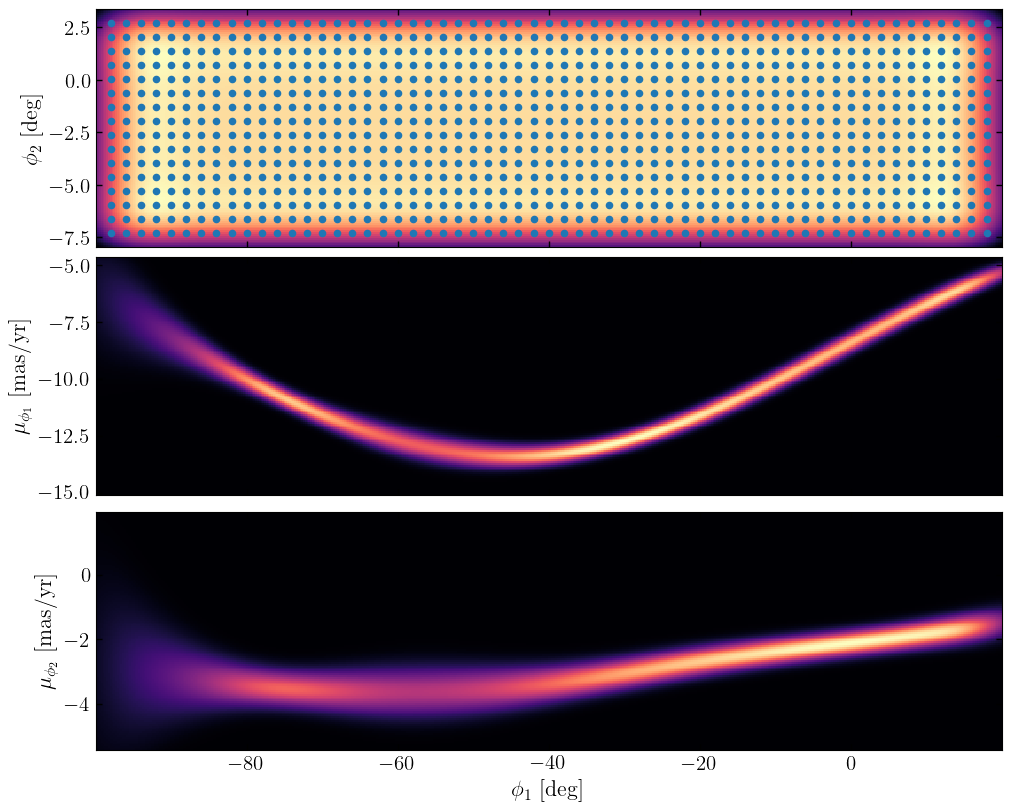

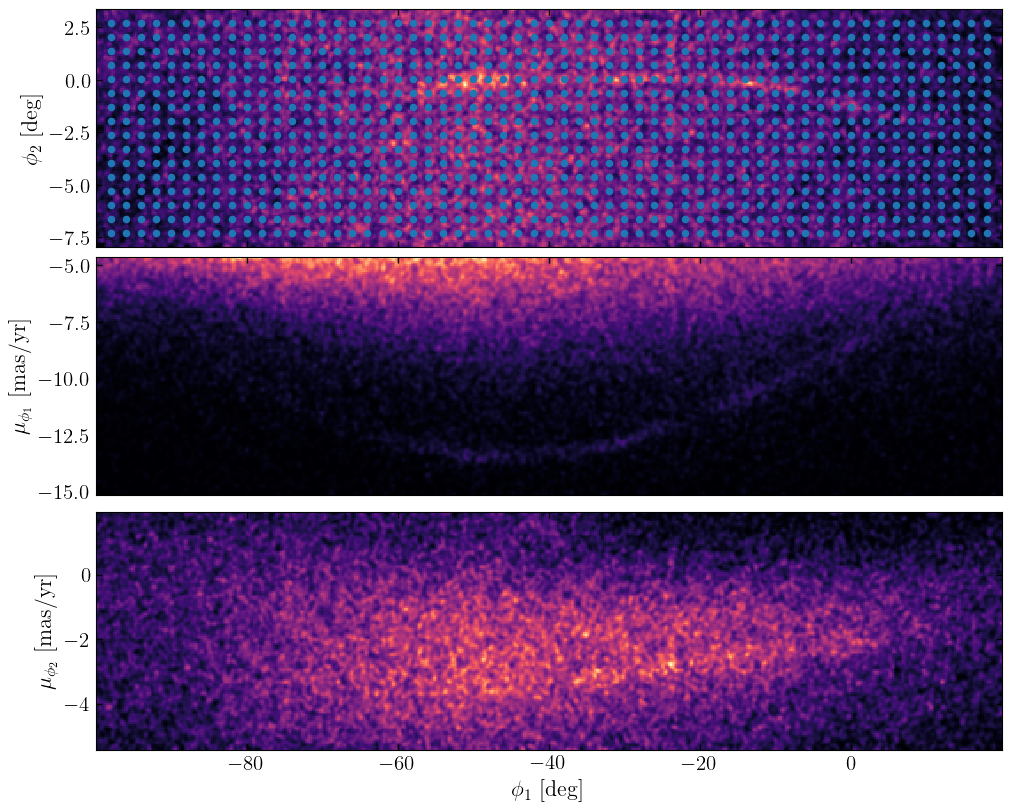

In [216]:
fig, axes, _ = offtrack_model.plot_model_projections(pars=offtrack_init_params, grids=plot_grids)
axes[0].scatter(
    offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=20
)

fig, axes, _ = plot_data_projections(data=run_data, grids=plot_grids)
axes[0].scatter(
    offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=20
)

In [24]:
mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0, 2.0])),
    components=[bkg_model, stream_model, offtrack_model],
    tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

In [82]:
mm_init_params = {
    "background": MAP_p_no_off_expanded["background"],
    "stream": MAP_p_no_off_expanded['stream'], # take from stream model rather than stream+background so that it doesn't have the spur
    "offtrack": offtrack_init_params,
}
mm_packed_params = mm.pack_params(mm_init_params)
mm_packed_params["mixture-probs"] = jnp.array([0.97, 0.02, 0.01])
mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

_ = mm.plot_model_projections(mm_packed_params, grids=plot_grids)

NameError: name 'MAP_p_no_off_expanded' is not defined

In [221]:
# TODO: do we need to pass in unconstrained parameter values?
# optimizer = numpyro.optim.Adam(1e-3, eps=1e-11)
optimizer = numpyro.optim.ClippedAdam(1e-2, eps=1e-10)
guide = AutoNormal(mm, init_loc_fn=numpyro.infer.init_to_value(values=mm_packed_params))
MAP_svi = SVI(mm, guide, optimizer, Trace_ELBO())

In [222]:
keys = jax.random.split(jax.random.PRNGKey(808), num=2)
with numpyro.validation_enabled(), jax.debug_nans():
    init_state = MAP_svi.init(keys[0], init_params=mm_packed_params, data=run_data)
    MAP_svi_results = MAP_svi.run(
        keys[1], 3_000, init_state=init_state, data=run_data
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [34:14<00:00,  1.46it/s, init loss: 790004.7318, avg. loss [2851-3000]: 768665.1153]


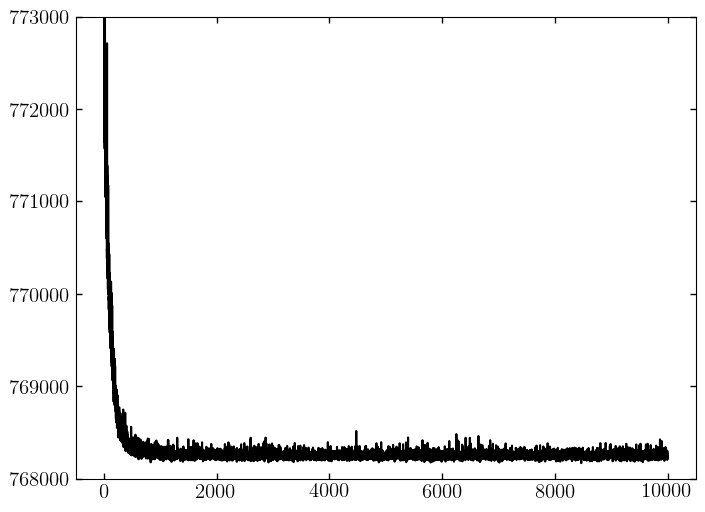

In [27]:
plt.plot(MAP_svi_results.losses)
# plt.yscale("symlog")
plt.ylim(768000,773000)

pred_dist = Predictive(guide, params=MAP_svi_results.params, num_samples=10_000)
MAP_p_ = pred_dist(jax.random.PRNGKey(42), data=run_data)
MAP_p = {k: jnp.median(v, axis=0) for k, v in MAP_p_.items()}
MAP_p_expanded = mm.expand_numpyro_params(MAP_p)

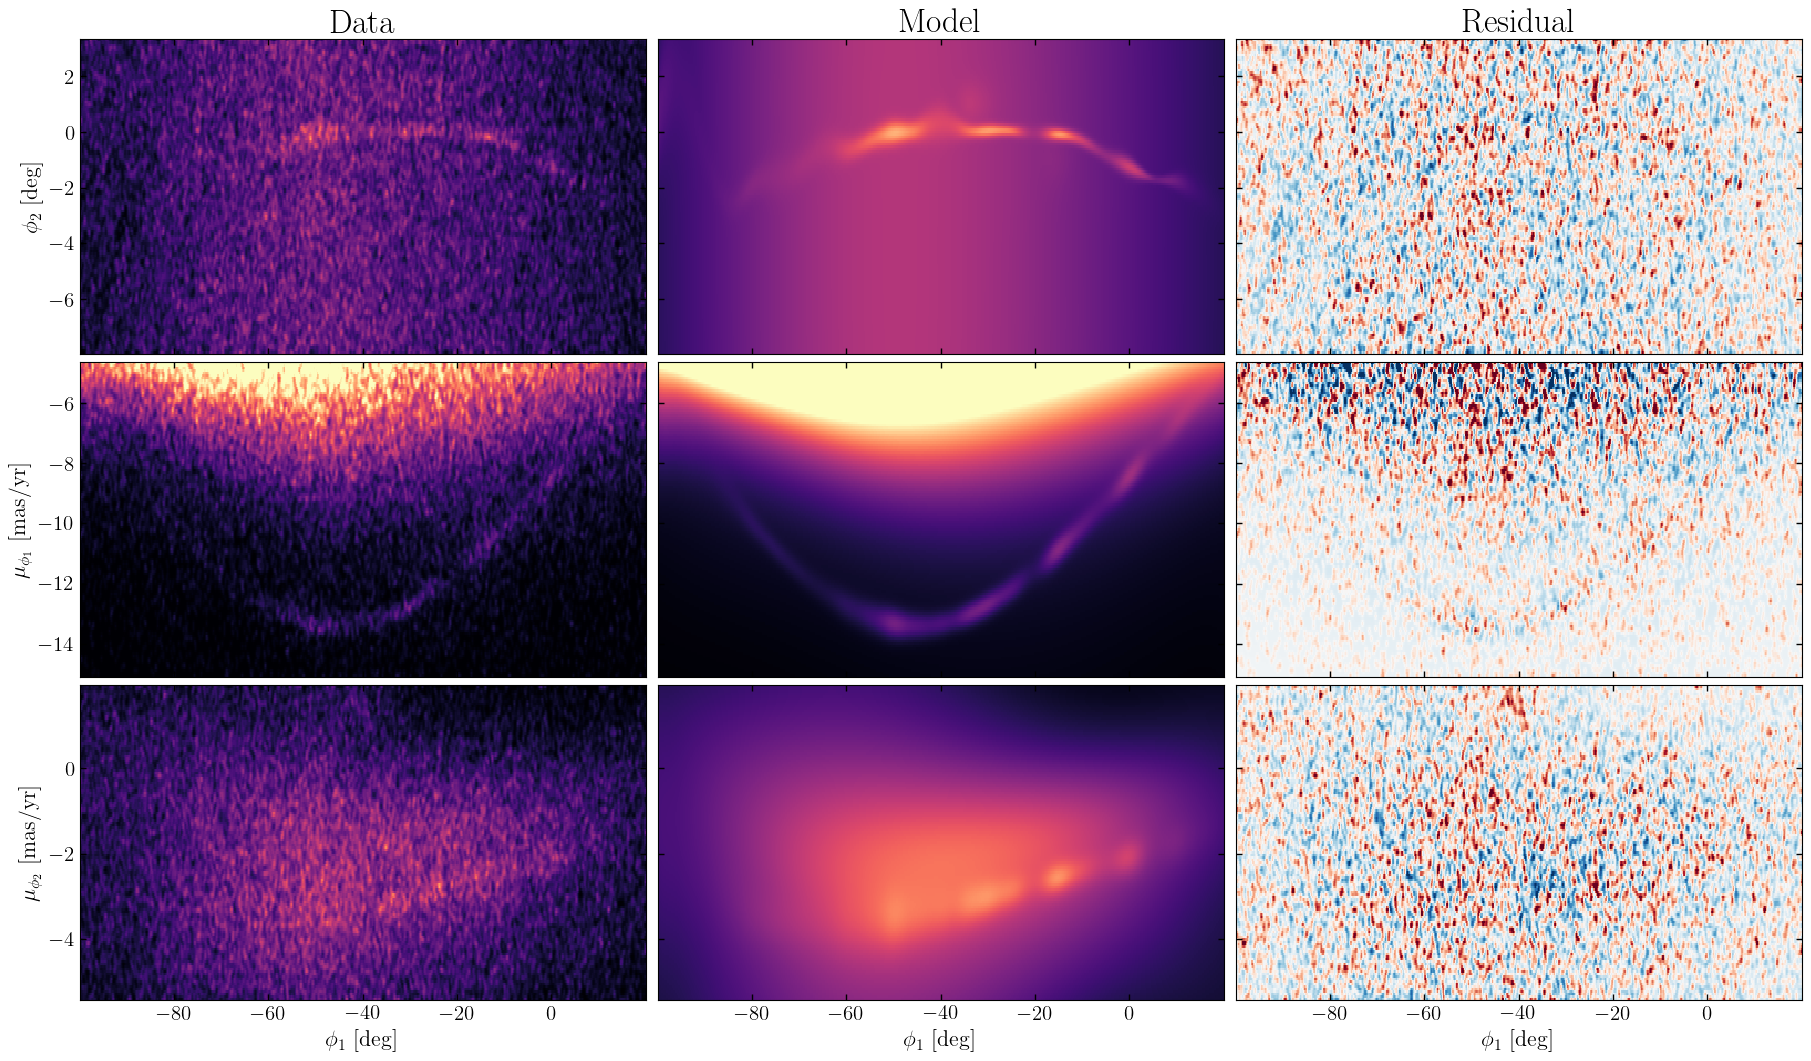

In [28]:
fig, axes = plt.subplots(
    len(mm.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(mm.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

#axes = jnp.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=plot_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmax=5, vmin=0)
    # coord_names=GD1BackgroundModel.coord_names,
)
mm.plot_model_projections(data=run_data, grids=plot_grids, pars=MAP_p_expanded, axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True, vmax=3, vmin=0))
mm.plot_residual_projections(
    grids=plot_grids, pars=MAP_p_expanded,
    data=run_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)

# plt.savefig('../figures/
plt.show()

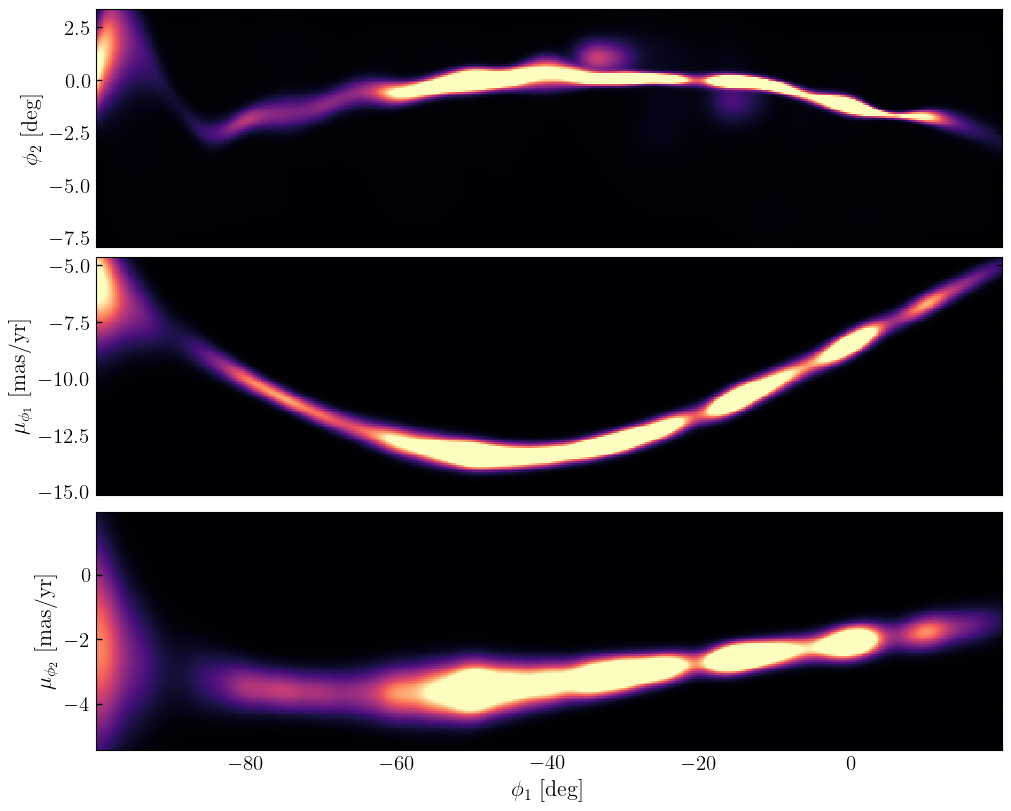

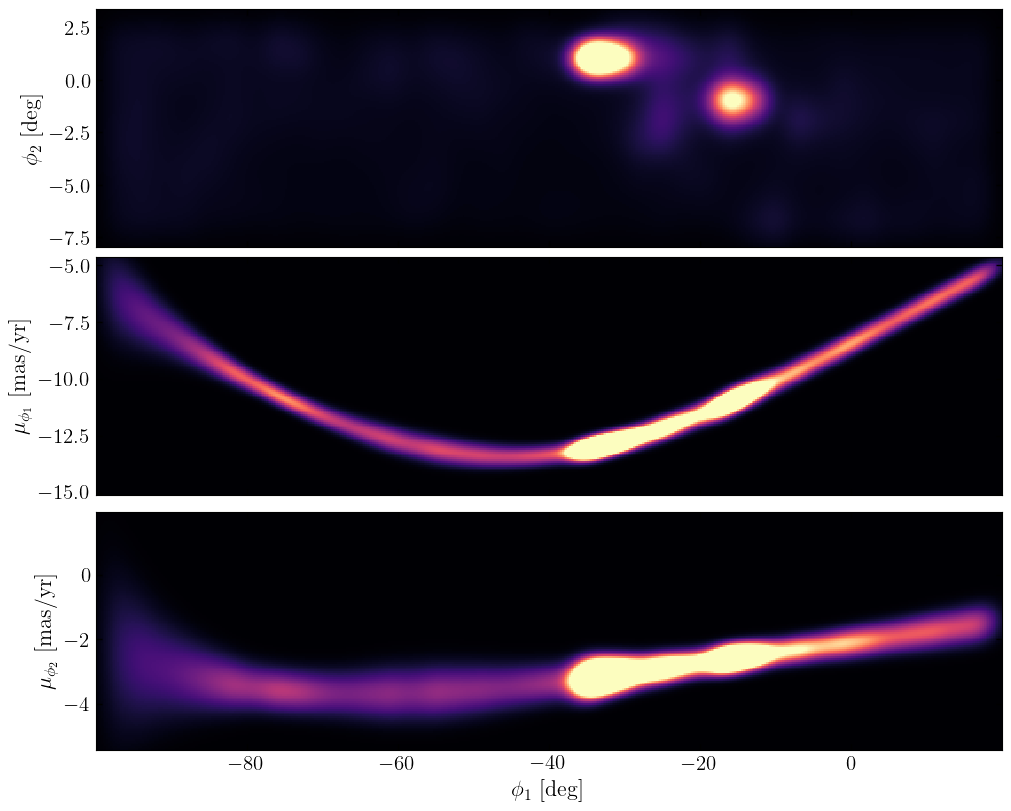

In [29]:
str_off_mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([1.0, 1.0])),
    components=[stream_model, offtrack_model],
    tied_coordinates={"offtrack": {"pm1": "stream", "pm2": "stream"}},
)

str_off_mm_params = {
    "stream": MAP_p_expanded["stream"],
    "offtrack": MAP_p_expanded["offtrack"],
}
str_off_mm_packed_params = str_off_mm.pack_params(str_off_mm_params)
str_off_mm_packed_params["mixture-probs"] = MAP_p_expanded["mixture-probs"][1:]
str_off_mm_packed_params["mixture"] = jnp.stack([v for v in run_data.values()], axis=-1)

_ = str_off_mm.plot_model_projections(pars=str_off_mm_packed_params, grids=plot_grids, pcolormesh_kwargs=dict(rasterized=True, vmax=0.0002, vmin=0))

_ = mm['offtrack'].plot_model_projections(grids=plot_grids, pars=MAP_p_expanded['offtrack'], pcolormesh_kwargs=dict(rasterized=True, vmax=0.01, vmin=0))

## Make Linear Density Plot

In [30]:
stream_opt = mm['stream']
offtrack_opt = mm['offtrack']

stream_params = MAP_p_expanded['stream']
offtrack_params = MAP_p_expanded['offtrack']

grids_stream, ln_ns_stream = stream_opt.evaluate_on_2d_grids(pars=stream_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])
grids_off, ln_ns_off = offtrack_opt.evaluate_on_2d_grids(pars=offtrack_params, grids=plot_grids, grid_coord_names=[("phi1", "phi2")])

In [31]:
phi1s = grids_stream[('phi1','phi2')][0][0][1:] - 0.1
stream_lin_dens = jnp.exp(ln_ns_stream[('phi1', 'phi2')]).sum(axis=0) / (phi1s[1]-phi1s[0])
off_lin_dens = jnp.exp(ln_ns_off[('phi1', 'phi2')]).sum(axis=0) / (phi1s[1]-phi1s[0])


phi2_track = IUS(stream_phi2_knots, stream_params['phi2']['loc_vals'])
phi2_width = IUS(stream_phi2_knots, stream_params['phi2']['scale_vals'])
pm1_track = IUS(stream_pm1_knots, stream_params['pm1']['loc_vals'])
pm1_width = IUS(stream_pm1_knots, stream_params['pm1']['scale_vals'])
pm2_track = IUS(stream_pm2_knots, stream_params['pm2']['loc_vals'])
pm2_width = IUS(stream_pm2_knots, stream_params['pm2']['scale_vals'])


# phi2_track_no_off = IUS(stream_phi2_knots, MAP_p_no_off_expanded['stream']['phi2']['loc_vals'])
# phi2_width_no_off = IUS(stream_phi2_knots, MAP_p_no_off_expanded['stream']['phi2']['scale_vals'])
# pm1_track_no_off = IUS(stream_pm1_knots, MAP_p_no_off_expanded['stream']['pm1']['loc_vals'])
# pm1_width_no_off = IUS(stream_pm1_knots, MAP_p_no_off_expanded['stream']['pm1']['scale_vals'])
# pm2_track_no_off = IUS(stream_pm2_knots, MAP_p_no_off_expanded['stream']['pm2']['loc_vals'])
# pm2_width_no_off = IUS(stream_pm2_knots, MAP_p_no_off_expanded['stream']['pm2']['scale_vals'])

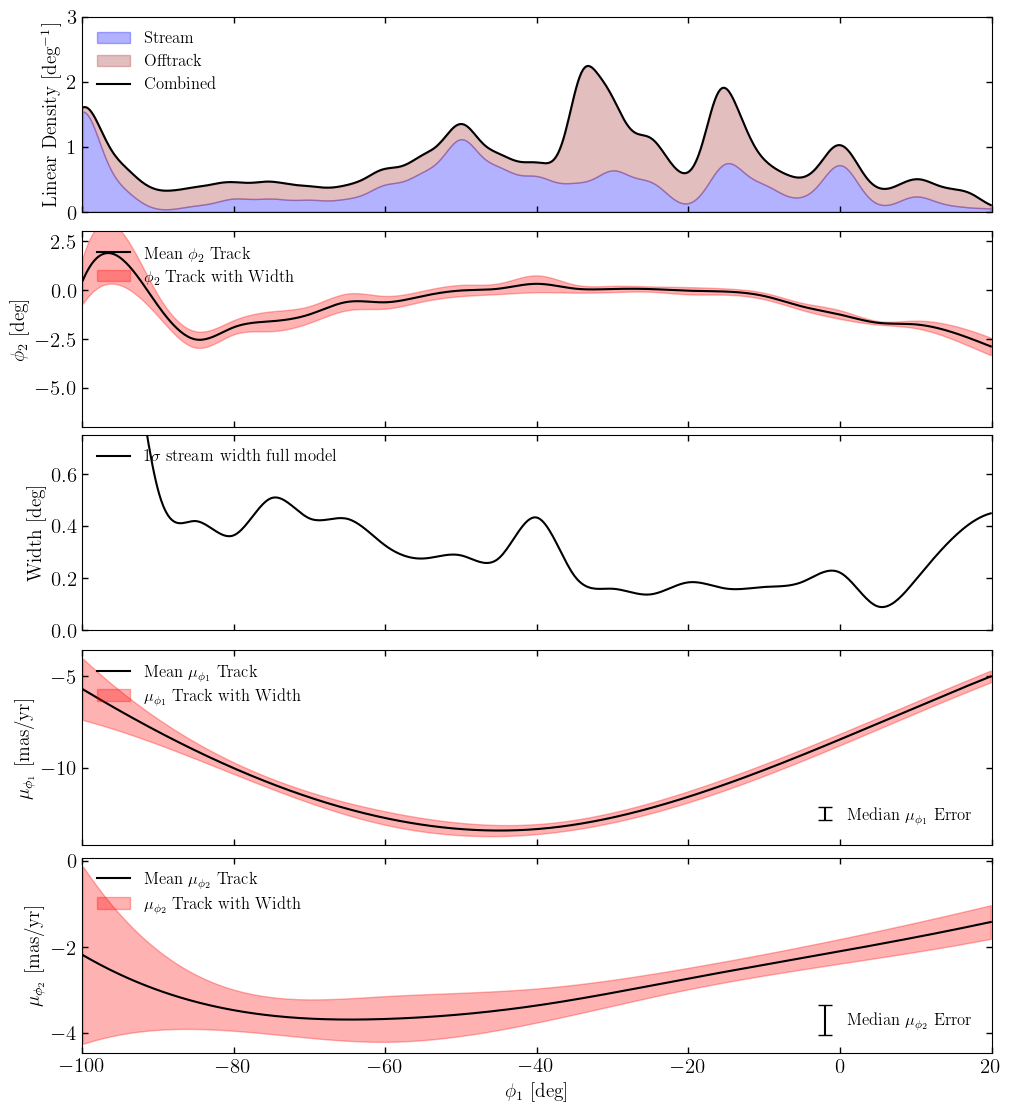

In [32]:
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(10,11), constrained_layout=True, sharex=True)
ax1.fill_between(phi1s, stream_lin_dens-stream_lin_dens, stream_lin_dens, color='b', alpha=0.3, label=r'Stream')
ax1.fill_between(phi1s, stream_lin_dens, stream_lin_dens+off_lin_dens, color='brown', alpha=0.3, label=r'Offtrack')
ax1.plot(phi1s, stream_lin_dens+off_lin_dens, color='k', label=r'Combined')
ax1.set_ylabel(r'Linear Density [deg$^{-1}$]', fontsize=14)
ax1.set_ylim(0,3)
ax1.legend(fontsize=12, loc='upper left')

ax2.plot(phi1s, phi2_track(phi1s), c='k', label=r'Mean $\phi_2$ Track')
ax2.fill_between(phi1s, phi2_track(phi1s) - phi2_width(phi1s), phi2_track(phi1s) + phi2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\phi_2$ Track with Width')
# ax2.fill_between(phi1s, phi2_track_no_off(phi1s) - phi2_width_no_off(phi1s), 
#                  phi2_track_no_off(phi1s) + phi2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\phi_2$ Track with Width')
ax2.set_ylim(-7, 3)
ax2.set_ylabel(r'$\phi_2$ [deg]', fontsize=14)
ax2.legend(fontsize=12, loc='upper left')

ax3.plot(phi1s, phi2_width(phi1s), c='k', label=r'$1\sigma$ stream width full model')
# ax3.plot(phi1s, phi2_width_no_off(phi1s), c='k', ls='dashed', label=r'$1\sigma$ stream width no offtrack')
ax3.set_ylim(0, 0.75)
ax3.set_ylabel(r'Width [deg]', fontsize=14)
ax3.legend(fontsize=12, loc='upper left')

ax4.plot(phi1s, pm1_track(phi1s), c='k', label=r'Mean $\mu_{\phi_1}$ Track')
ax4.errorbar(-2, -12.5, yerr=0.35, fmt='', capsize=5, color='black')
ax4.text(1, -12.8, r'Median $\mu_{\phi_1}$ Error', fontsize=12)
ax4.fill_between(phi1s, pm1_track(phi1s) - pm1_width(phi1s), pm1_track(phi1s) + pm1_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
# ax4.fill_between(phi1s, pm1_track_no_off(phi1s) - pm1_width_no_off(phi1s), 
#                  pm1_track_no_off(phi1s) + pm1_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_1}$ Track with Width')
ax4.set_ylabel(r'$\mu_{\phi_1}$ [mas/yr]', fontsize=14)
ax4.legend(fontsize=12, loc='upper left')

ax5.plot(phi1s, pm2_track(phi1s), c='k', label=r'Mean $\mu_{\phi_2}$ Track')
ax5.errorbar(-2, -3.7, yerr=0.35, fmt='', capsize=5, color='black')
ax5.text(1, -3.8, r'Median $\mu_{\phi_2}$ Error', fontsize=12)
ax5.fill_between(phi1s, pm2_track(phi1s) - pm2_width(phi1s), pm2_track(phi1s) + pm2_width(phi1s), 
                 color='r', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
# ax5.fill_between(phi1s, pm2_track_no_off(phi1s) - pm2_width_no_off(phi1s), 
#                  pm2_track_no_off(phi1s) + pm2_width_no_off(phi1s), 
#                  color='b', alpha=0.3, label=r'$\mu_{\phi_2}$ Track with Width')
ax5.set_ylabel(r'$\mu_{\phi_2}$ [mas/yr]', fontsize=14)
ax5.legend(fontsize=12, loc='upper left')

ax5.set_xlim(-100, 20)
ax5.set_xlabel(r'$\phi_1$ [deg]', fontsize=14)

# plt.savefig('../paper_figures/stream_properties.pdf')
plt.show()

In [33]:
all_data_ = iso_obj.cat[pm_mask]
all_data = {k: jnp.array(all_data_[k], dtype="f8") for k in all_data_.colnames}

In [34]:
lp_dict = {}
for n_comp, component in enumerate(mm.components):
    
    print(component.name)
    dists = component.make_dists(MAP_p_expanded[component.name])

    component_lp_stack = jnp.empty((len(dists), len(all_data_)))

    for i, (coord_name, dist_) in enumerate(dists.items()):
        if isinstance(coord_name, tuple):
            _data = jnp.stack([all_data[k] for k in coord_name], axis=-1)
        else:
            _data = jnp.asarray(all_data[coord_name])

        if isinstance(dist_, (IndependentGMM, dist.Uniform)):
            variable_lp  = dist_.log_prob(value=_data)
        else:
            variable_lp = dist_.log_prob(value=_data, x=jnp.asarray(all_data['phi1']))
        component_lp_stack = component_lp_stack.at[i].set(variable_lp)
    # comp_lp = jax.scipy.special.logsumexp(component_lp_stack, axis=0) +lp
    comp_lp = jnp.sum(component_lp_stack, axis=0) + jnp.log(MAP_p_expanded['mixture-probs'][n_comp])
    lp_dict[component.name] = comp_lp
    print(comp_lp, jnp.max(comp_lp)) 

background
[-10.74322282 -10.04426366 -12.17555235 ... -11.53353703 -13.00864762
 -11.3094444 ] -9.519001621647504
stream
[-292.95504466 -267.32169796 -127.04124017 ... -239.20728825 -165.45696089
 -191.12199089] -6.367303430439458
offtrack
[-197.0891223  -171.6290783   -31.97787474 ... -114.38780148  -42.41538928
  -64.01355956] -8.631283076075572


In [35]:
sum_probs = jnp.exp(lp_dict['background']) + jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])

In [36]:
memb_prob = (jnp.exp(lp_dict['stream']) + jnp.exp(lp_dict['offtrack'])) / sum_probs
print((memb_prob > 0.5).sum())
print((memb_prob > 0.75).sum())
print((memb_prob > 0.9).sum())
print((memb_prob > 0.99).sum())

3490
2138
1629
573


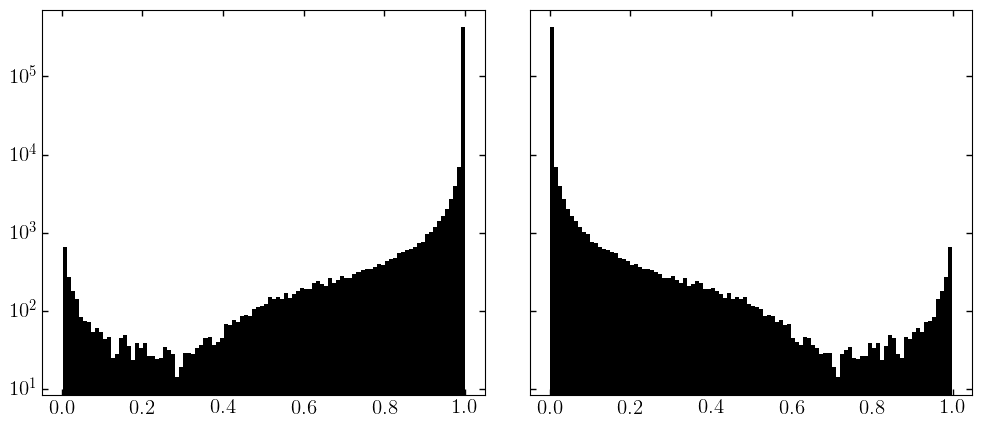

In [37]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12,5), sharey=True)
ax1.hist(jnp.exp(lp_dict['background']) / sum_probs, bins=100)
ax1.set_yscale('log')

ax2.hist(memb_prob, bins=100)
ax2.set_yscale('log')

plt.show()

In [38]:
memb_sel1 = np.array(memb_prob>0.5)
memb_sel2 = np.array(memb_prob>0.75)
memb_sel3 = np.array(memb_prob>0.9)
bad_cmd_sel = (all_data_['g0'] - all_data_['r0']) > 1.5

In [39]:
print(len(all_data_[memb_sel1]))
print(len(all_data_[memb_sel1&~bad_cmd_sel]))

3490
3483


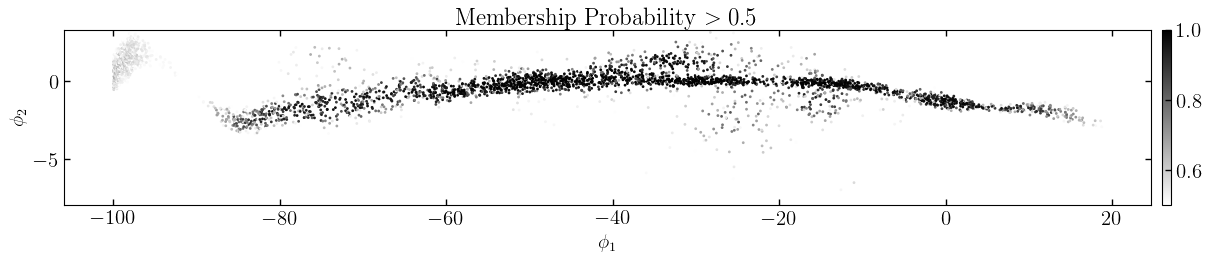

In [40]:
# fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
# ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], s=1)
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
# ax1.set_title(r'Membership Probability $> 0.5$')
# ax1.set_ylim(*phi2_lim)

# ax2.scatter(all_data_[memb_sel2]['phi1'], all_data_[memb_sel2]['phi2'], s=1)
# ax2.set_title(r'Membership Probability $> 0.75$')

# ax3.scatter(all_data_[memb_sel3]['phi1'], all_data_[memb_sel3]['phi2'], s=1)
# ax3.set_title(r'Membership Probability $> 0.9$')

# ax3.set_xlabel(r'$\phi_1$')
# plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(12,2.5), sharex=True, sharey=True, constrained_layout=True)
im1 = ax1.scatter(all_data_[memb_sel1]['phi1'], all_data_[memb_sel1]['phi2'], c=memb_prob[memb_sel1], s=1, vmin=0.5, vmax=1, cmap='gray_r')
# ax1.scatter(all_data_[memb_sel1&bad_cmd_sel]['phi1'], all_data_[memb_sel1&bad_cmd_sel]['phi2'], s=1, c='r')
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_ylim(*phi2_lim)
ax1.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
cbar = fig.colorbar(im1, ax=ax1, pad=0.01)
plt.show()

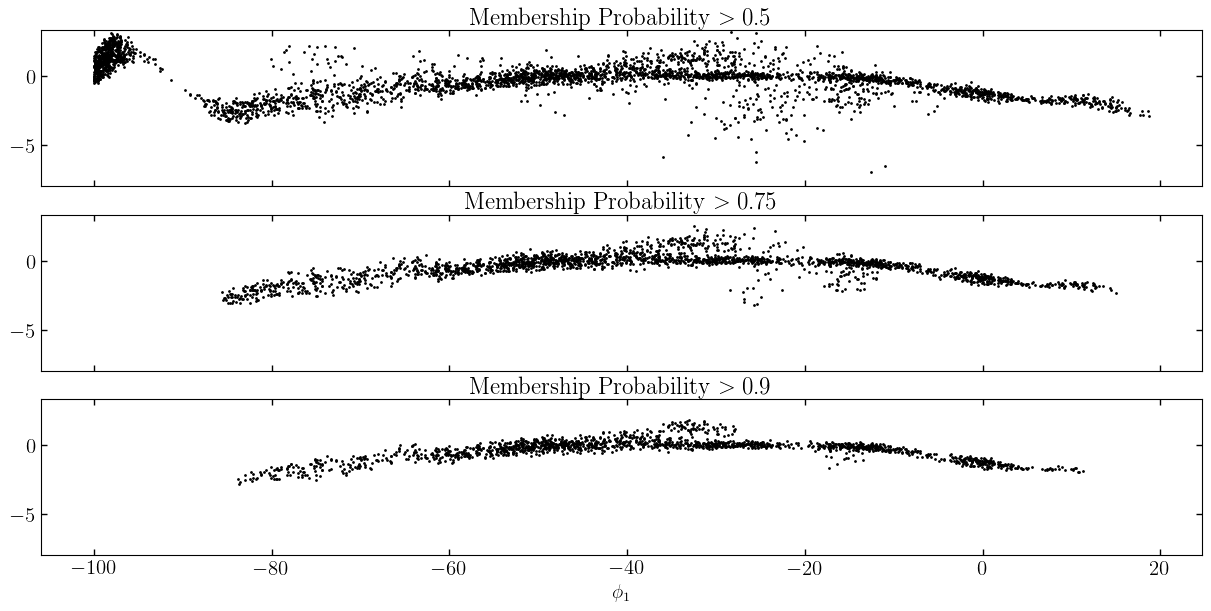

In [41]:
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel1&~bad_cmd_sel]['phi1'], all_data_[memb_sel1&~bad_cmd_sel]['phi2'], s=1)
ax1.set_title(r'Membership Probability $> 0.5$')
ax1.set_ylim(*phi2_lim)

ax2.scatter(all_data_[memb_sel2&~bad_cmd_sel]['phi1'], all_data_[memb_sel2&~bad_cmd_sel]['phi2'], s=1)
ax2.set_title(r'Membership Probability $> 0.75$')

ax3.scatter(all_data_[memb_sel3&~bad_cmd_sel]['phi1'], all_data_[memb_sel3&~bad_cmd_sel]['phi2'], s=1)
ax3.set_title(r'Membership Probability $> 0.9$')

ax3.set_xlabel(r'$\phi_1$')
plt.show()

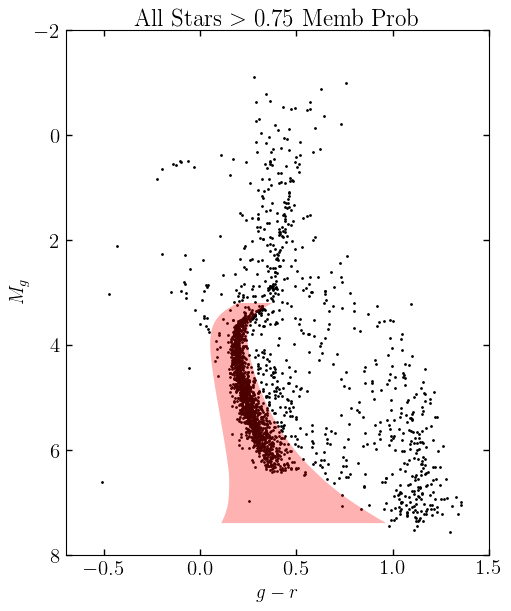

In [42]:
distmod_spl = np.poly1d([2.41e-4, 2.421e-2, 15.001])
dist_mod_correct_all = distmod_spl(all_data_[memb_sel2&~bad_cmd_sel]["phi1"]) - iso_obj.dist_mod


fig, ax1 = plt.subplots(1, 1, figsize=(5,6), sharey=True, sharex=True, constrained_layout=True)
ax1.scatter(all_data_[memb_sel2&~bad_cmd_sel]['g0'] - all_data_[memb_sel2&~bad_cmd_sel]['r0'], 
            all_data_[memb_sel2&~bad_cmd_sel]['g0'] - dist_mod_correct_all  - iso_obj.dist_mod, 
            c='k', s=1)
cmd_poly = iso_obj.pawprint.cmdprint.vertices - jnp.array([0,iso_obj.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, facecolor="red", alpha=0.3)
ax1.add_patch(cmd_patch)
ax1.set_title(r'All Stars $>0.75$ Memb Prob')

ax1.set_xlabel(r'$g-r$', fontsize=14)
ax1.set_ylabel(r'$M_g$', fontsize=14)

ax1.set_xlim(-0.7, 1.5)
ax1.set_ylim(8, -2)
plt.show()